In [2]:
# Created by Benjamin Staar
# Licence: GNU GPLv3 

from keras.layers import *
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import tensorflow_probability as tfp


import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [82]:
path = '../datasets/DAGM2007/'

In [83]:
# for random projection initialize with random matrix whose columns have unit length 
def rp_init(shape, dtype=None):
    W = K.random_normal(shape, dtype=dtype,seed=1)
    print('W:',K.int_shape(W))
    W = K.l2_normalize(W,axis=-1)
    return W

def rp_lecun_init(shape, dtype=None):
    init = tf.keras.initializers.lecun_normal()
    print(dir(init))
    W = init(shape,dtype)
    print('W:',K.int_shape(W))
    W = K.l2_normalize(W,axis=-1)
    return W

In [84]:
def Mahalanobis_distance(x):
    # Calculate Mahalanobis distance from distribution center for each sample 
    # in a data matrix by first applying ZCA-Whitening (decorrelate+normalize)
    # and then taking the squared sum over the (whitened) features
    # x: list [covariance matrix, data]
    cov = x[0]
    data = x[1]
    # SVD
    s, u, v = tf.linalg.svd(cov)
    # create whitening matrix
    norm = tf.linalg.tensor_diag(1./(K.sqrt(s+K.epsilon())))
    zca = K.dot( u, K.dot( norm, K.permute_dimensions(u,(1,0))))
    # whiten (decorrelate+normalize) the data
    white1 = K.dot(zca,K.permute_dimensions(data,(1,0)))
    # calculate Mahalnobis distance from distribution center for each data point
    md = K.permute_dimensions(white1,(1,0))
    md = K.sum(md**2,axis=1,keepdims=True)
    return md

def Batch_Mahalanobis_distance(data):
    # 0: get number of samples for later normalization
    N = K.int_shape(data)[1]
    # 1: subtract mean
    mu = tf.reduce_mean(data,1,keepdims=True)
    data-=mu
    # 2: get covariance
    cov = K.batch_dot(K.permute_dimensions(data,(0,2,1)),data)
    cov = tf.divide(cov,N)
    # 3: Get Mahalanobis Distance
    md = tf.map_fn(Mahalanobis_distance,[cov,data],dtype=tf.float32)
    return md

def Mahalanobis_Layer(x):
    _,D1,D2,D3 = K.int_shape(x)
    x = Reshape((-1,D3))(x)
    x = Lambda(Batch_Mahalanobis_distance)(x)
    return Reshape((D1,D2,1))(x)

In [112]:
def Mahalanobis_keras(Dims,patch_size,step,compressed_dim=64,random_projection=False):
    # Build a keras model that calculates the Mahalanobis distance 
    # of image patches of the mean.
    # Random projections help to speed up the calculations.
    # They are implemented via a convolutional layer, which also opens the possibility 
    # to get "optimized projections" via training
    
    tfd = tfp.distributions
    chi2_dist = tfd.Chi2(compressed_dim)
    def chi2(x):
        return chi2_dist.log_prob(x)

    def get_patches(x):
        ksizes = [1,patch_size,patch_size,1]
        strides = [1,step,step,1]
        patches = tf.image.extract_image_patches(x,ksizes,strides,[1,1,1,1],padding='VALID')
        return patches

    inp = Input(shape=(Dims, Dims,1))
    if random_projection:
        x = Conv2D(compressed_dim,(patch_size,patch_size),strides=(step,step),kernel_initializer=rp_init)(inp)
    else:
        H = patch_size**2
        x = Lambda(get_patches)(inp)
    
    
    mah = Mahalanobis_Layer(x)#Lambda(Mahalanobis_distance)(x)
    out = Activation(chi2)(mah)
    model = Model(inp,out)
    mah_dist = Model(inp,mah)
    model.compile(loss='mae', optimizer='adam')
    return model,mah_dist

In [113]:
# initialized model
model,MD = GauMah(512,16,2,random_projection=True)

W: (16, 16, 1, 64)


In [159]:
def plot_result(files_def,n=2,sn=None):
    ts = []
    z=1
    plt.figure(1,figsize=(12,9))
    for f in files_def[:2]:
        t0 = time.time()
        im = np.expand_dims( np.expand_dims(cv2.imread(f,0),0) ,-1)
        p = model.predict(im)
        if sn is not None:
            p-=(.0001+np.nanmean(sn,axis=0))
            p/=(.0001+np.nanstd(sn,axis=0))
        
        ts.append(time.time()-t0)
        plt.subplot(3,2,z)
        plt.imshow(im[0,:,:,0],cmap='gray')
        plt.axis('off')
        plt.subplot(3,2,z+1)
        print(sn.shape)
#         plt.hist(sn[:,0,12,12,0].flatten())
        plt.imshow(p[0,:,:,0],cmap='jet'),plt.colorbar()
        plt.axis('off')
        z+=2
    plt.show()
    return ts

In [160]:
def stats_norm(files):
    Ps = []
    
    for f in files:
        im = np.expand_dims( np.expand_dims(cv2.imread(f,0),0) ,-1)
        p = model.predict(im)
        Ps.append(p.copy())
    return np.asarray(Ps)

(100, 1, 249, 249, 1)
(100, 1, 249, 249, 1)


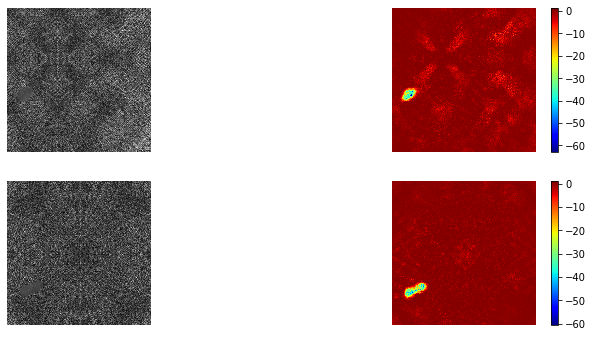

(100, 1, 249, 249, 1)
(100, 1, 249, 249, 1)


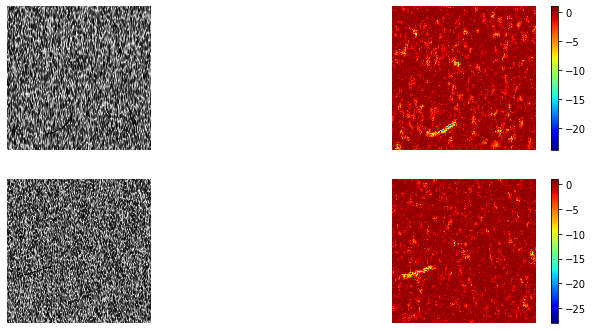

(100, 1, 249, 249, 1)
(100, 1, 249, 249, 1)


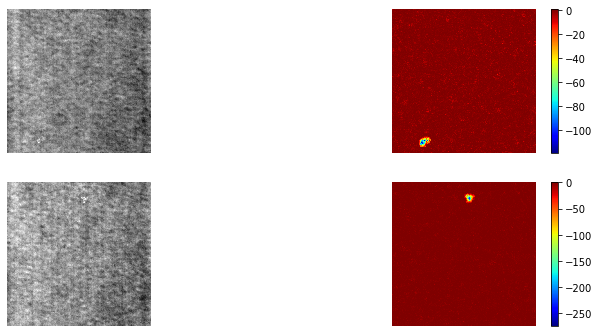

(100, 1, 249, 249, 1)
(100, 1, 249, 249, 1)


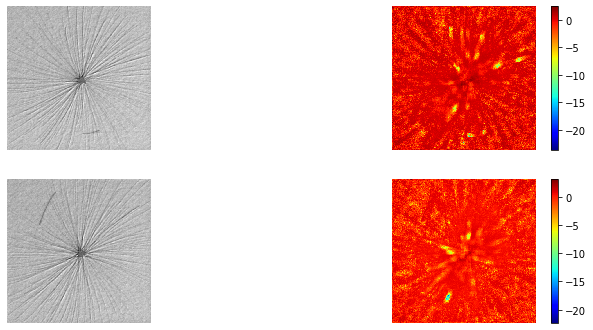

(100, 1, 249, 249, 1)
(100, 1, 249, 249, 1)


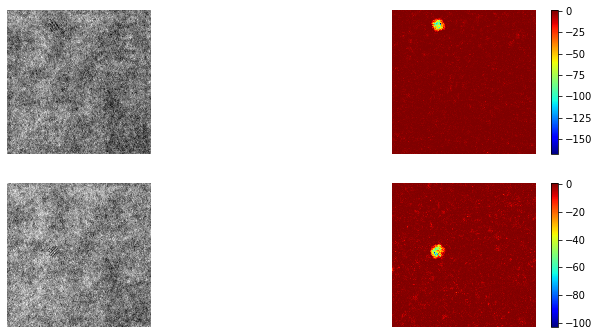

(100, 1, 249, 249, 1)
(100, 1, 249, 249, 1)


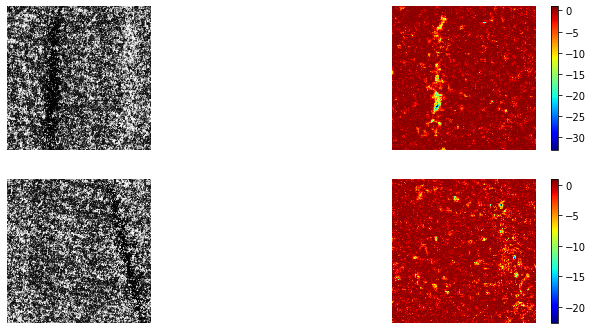

(100, 1, 249, 249, 1)
(100, 1, 249, 249, 1)


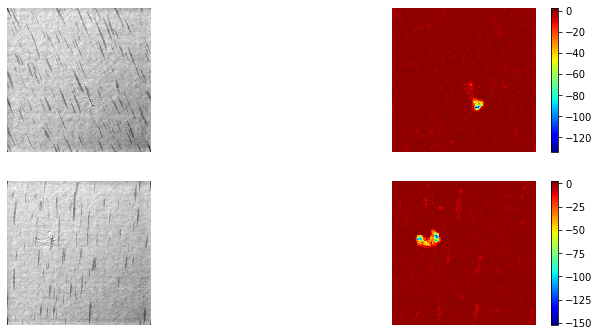

(100, 1, 249, 249, 1)
(100, 1, 249, 249, 1)


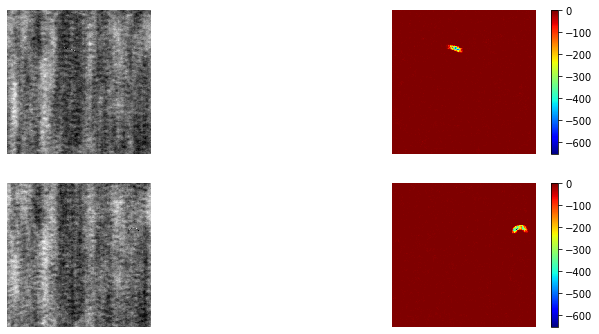

(100, 1, 249, 249, 1)
(100, 1, 249, 249, 1)


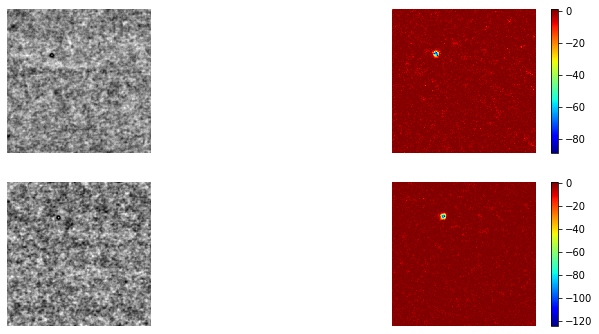

(100, 1, 249, 249, 1)
(100, 1, 249, 249, 1)


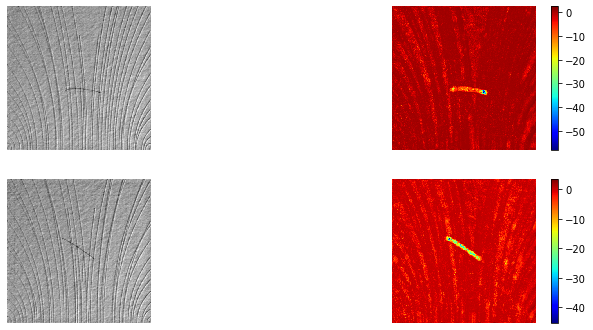

In [161]:
T = []
Class = ['1','2','3','4','5','6','7','8','9','10']
for c in Class:
    Files = glob.glob(path+'Class'+c+'/*.png')+glob.glob(path+'Class'+c+'/*.PNG')
    Files_def = glob.glob(path+'Class'+c+'_def/*.png')+glob.glob(path+'Class'+c+'_def/*.PNG')
    if os.pa
    SN = stats_norm(Files)
    T.extend( plot_result(Files_def,sn=SN))

(array([3., 2., 1., 4., 2., 1., 6., 0., 0., 1.]),
 array([0.04571867, 0.04663544, 0.0475522 , 0.04846897, 0.04938574,
        0.05030251, 0.05121927, 0.05213604, 0.05305281, 0.05396957,
        0.05488634]),
 <a list of 10 Patch objects>)

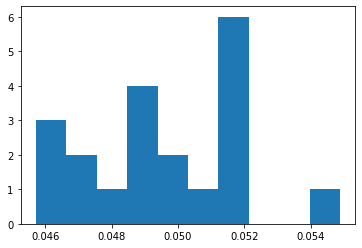

In [162]:
plt.hist(T)